# **Programming Assignment 2 - Object Detection + Semantic Segmentation**

#### **Professor**: Dário Oliveira  
#### **Monitora**: Lívia Meinhardt


O objetivo deste trabalho é construir um pipeline de visão computacional que primeiro **detecta** objetos em uma imagem e, em seguida, realiza a **segmentação semântica** em cada objeto detectado. Ou seja, uma segmentação de instância em duas etapas.

Vocês irão construir e conectar dois modelos distintos:
1.  Um **detector de objetos** (YOLO) para encontrar a localização dos objetos.
2.  Um **segmentador semântico** (U-Net ou outro) para classificar os pixels dentro de cada objeto localizado.

### **Instruções:**

1. **Criação de um Dataset**:  
Vocês usarão o dataset **[PASCAL VOC 2012](https://www.kaggle.com/datasets/gopalbhattrai/pascal-voc-2012-dataset)**. Este conjunto de dados é ideal porque fornece anotações tanto para **caixas delimitadoras** (*bounding boxes*), para a tarefa de detecção, quanto para **máscaras de segmentação** a nível de pixel.


2. **Implementação e Treinamento da YOLO:**
Sua primeira tarefa é fazer a implementação da YOLOv3, vista em aula. Treine um modelo que recebe uma imagem como entrada e retorna uma lista de predições, onde cada predição contém `(caixa_delimitadora, classe, score_de_confiança)`. Meça o desempenho do seu detector usando a métrica **Mean Average Precision (mAP)**.


3. **Treinar o Segmentador Semântico:**
Sua segunda tarefa é treinar um modelo **U-Net** ou outro de sua preferência para realizar a segmentação. O ponto crucial é que vocês não irão treinar a U-Net com imagens inteiras. Em vez disso, vocês a treinarão com **recortes de imagem (*patches*)** gerados a partir das caixas delimitadoras de referência (*ground-truth*) do dataset. Meça o desempenho do seu segmentador usando a métrica **Average Precision (AP).**

4. **Construir o Pipeline de Inferência:**
    Agora, conecte seus dois modelos treinados. Esta parte envolve escrever um script que executa a tarefa completa de ponta a ponta.

    1.  **Detectar**: Use uma nova imagem de teste e passe-a pelo seu modelo **YOLOv3** treinado para obter uma lista de caixas delimitadoras preditas.
    2.  **Recortar**: Para cada predição de alta confiança do YOLO, **recorte o *patch* da imagem** definido pela caixa delimitadora.
    3.  **Segmentar**: Passe cada *patch* recortado pelo seu modelo **U-Net** treinado para obter uma máscara de segmentação para aquele objeto específico.
    4.  **Combinar**: Crie uma imagem em branco (preta) do mesmo tamanho da imagem original. "Costure" cada máscara gerada de volta nesta imagem em branco, na sua localização original da caixa delimitadora.
    5.  **Visualizar**: Sobreponha a máscara final combinada na imagem original para criar uma visualização final mostrando todos os objetos detectados e segmentados.


5. **Compare com um método *end-to-end:***
Por fim, faça *fine-tuning* do [**Mask R-CNN**](https://docs.pytorch.org/vision/main/models/mask_rcnn.html), um um modelo de segmentação de instância de ponta a ponta (*end-to-end*). Compare o desempenho com o seu pipeline de dois estágios e discuta as diferenças.


### **Entrega:**

Você deve enviar:

1.  Um **Jupyter Notebook** contendo todo o seu código.
2.  Os **pesos treinados** tanto do seu detector YOLOv3 quanto do seu segmentador U-Net.
3.  Um **relatório ou apresentação** que discuta os desafios e resultados dos seus experimentos.

## Preparando o dataset pra detecção

In [1]:
import kagglehub
gopalbhattrai_pascal_voc_2012_dataset_path = kagglehub.dataset_download('gopalbhattrai/pascal-voc-2012-dataset')

print('Data source import complete.')

ModuleNotFoundError: No module named 'kagglehub'

In [2]:
gopalbhattrai_pascal_voc_2012_dataset_path = "data"

In [3]:
import os
import random
from tqdm import tqdm
from PIL import Image
import shutil

# Define dataset root
original_dataset_path = gopalbhattrai_pascal_voc_2012_dataset_path
yolo_dataset_path = 'yolo_dataset'
unet_dataset_path = 'unet_dataset'

In [3]:
yolo_dirs = [
    os.path.join(yolo_dataset_path, 'images', 'train'),
    os.path.join(yolo_dataset_path, 'images', 'val'),
    os.path.join(yolo_dataset_path, 'labels', 'train'),
    os.path.join(yolo_dataset_path, 'labels', 'val')
]

for yolo_dir in yolo_dirs:
    os.makedirs(yolo_dir, exist_ok=True)

jpeg_images_dir = os.path.join(original_dataset_path, 'VOC2012_train_val', 'VOC2012_train_val', 'JPEGImages')
annotations_dir = os.path.join(original_dataset_path, 'VOC2012_train_val', 'VOC2012_train_val', 'Annotations')

if not os.path.exists(jpeg_images_dir) or not os.path.exists(annotations_dir):
    raise FileNotFoundError(
        f"""
        The directory {jpeg_images_dir} or {annotations_dir} does not exist. Please verify the dataset path.
        """
    )

image_filenames = os.listdir(jpeg_images_dir)
image_ids = [os.path.splitext(filename)[0] for filename in image_filenames if filename.endswith('.jpg')]

random.seed(42)
random.shuffle(image_ids)
split_index = int(0.8 * len(image_ids)) # Spliting the dataset 80% for training, 20% for validation
train_ids = image_ids[:split_index]     # Taking the first 80% pictures
val_ids = image_ids[split_index:]

In [4]:
unet_dirs = [
    os.path.join(unet_dataset_path, 'images', 'train'),
    os.path.join(unet_dataset_path, 'images', 'val'),
    os.path.join(unet_dataset_path, 'labels', 'train'),
    os.path.join(unet_dataset_path, 'labels', 'val')
]

segmentation_dir = os.path.join(original_dataset_path, 'VOC2012_train_val', 'VOC2012_train_val', 'SegmentationObject')

for unet_dir in unet_dirs:
    os.makedirs(unet_dir, exist_ok=True)

segmentation_filenames = os.listdir(segmentation_dir)
segmentation_ids = [os.path.splitext(filename)[0] for filename in segmentation_filenames if filename.endswith('.png')]


In [5]:
import xml.etree.ElementTree as ET

# This function converts PASCAL_VOC annotations to YOLO format
def create_yolo_annotation(xml_file_path, yolo_label_path, label_dict):
    classes_list = []
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    annotations = [] # List that will store the converted YOLO annotations
    crop_boxes = []

    img_width = int(root.find('size/width').text)
    img_height = int(root.find('size/height').text)


    for obj in root.findall('object'):
        label = obj.find('name').text
        if label not in label_dict:
            continue
        label_idx = label_dict[label]
        bndbox = obj.find('bndbox')
        xmin = float(bndbox.find('xmin').text)
        ymin = float(bndbox.find('ymin').text)
        xmax = float(bndbox.find('xmax').text)
        ymax = float(bndbox.find('ymax').text)

        # This is YOLOv8 annotation format: label x_center y_center width height (normalized)
        x_center = ((xmin + xmax) / 2) / img_width
        y_center = ((ymin + ymax) / 2) / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height

        annotations.append(f"{label_idx} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
        crop_boxes.append((xmin, ymin, xmax, ymax))
        classes_list.append(label_idx)

    # Annotations to the label file
    with open(yolo_label_path, 'w') as f:
        f.write("\n".join(annotations))

    return crop_boxes, classes_list

In [6]:
label_dict = {
    'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4,
    'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9,
    'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14,
    'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19
}

crop_boxes = dict()
classes_boxes = dict()

for image_set, ids in [('train', train_ids), ('val', val_ids)]:
    ids.sort()
    for img_id in tqdm(ids, desc=f"Processing {image_set}"):
        img_src_path = os.path.join(jpeg_images_dir, f'{img_id}.jpg')
        label_dst_path = os.path.join(yolo_dataset_path, 'labels', image_set, f'{img_id}.txt')
        
        # Create the YOLO annotation file
        xml_file_path = os.path.join(annotations_dir, f'{img_id}.xml')
        if not os.path.exists(xml_file_path):
            print(f"Warning: Annotation {xml_file_path} not found, skipping.")
            continue

        crop_boxes[img_id], classes_boxes[img_id] = create_yolo_annotation(xml_file_path, label_dst_path, label_dict)

        # Copy the image to the new YOLO dataset structure
        img_dst_path = os.path.join(yolo_dataset_path, 'images', image_set, f'{img_id}.jpg')

        shutil.copy(img_src_path, img_dst_path)

gt_seg_counter = 0
for key in segmentation_ids:
    gt_seg_counter += len(crop_boxes[key])

Processing val: 100%|██████████| 3425/3425 [00:01<00:00, 3106.43it/s]


In [7]:
random.seed(42)
random.shuffle(segmentation_ids)
split_index_seg = int(0.8 * gt_seg_counter) # Spliting the dataset 80% for training, 20% for validation

In [8]:
most_frequent_colors = {}
split_counter = 0
for img_id in segmentation_ids:
    img_src_path = os.path.join(jpeg_images_dir, f"{img_id}.jpg")
    seg_src_path = os.path.join(segmentation_dir, f"{img_id}.png")
    original_img = Image.open(img_src_path)
    original_seg = Image.open(seg_src_path)

    for i, crop_box in enumerate(crop_boxes[img_id]):
        cropped_img = original_img.crop(crop_box)
        cropped_seg = original_seg.crop(crop_box)

        cropped_img_filename = f"{img_id}_{i}_{classes_boxes[img_id][i]}.jpg"
        cropped_seg_filename = f"{img_id}_{i}_{classes_boxes[img_id][i]}.png"

        place = "train" if split_counter < split_index_seg else "val"
        split_counter += 1

        output_img_path = os.path.join(unet_dataset_path, "images", place, cropped_img_filename)
        output_seg_path = os.path.join(unet_dataset_path, "labels", place, cropped_seg_filename)

        cropped_img.save(output_img_path)
        cropped_seg.save(output_seg_path)

        img_rgb = cropped_seg.convert("RGB")
        colors = img_rgb.getcolors(img_rgb.size[0] * img_rgb.size[1])
            
        if colors:
            most_frequent_color = sorted(colors, key=lambda item: item[0], reverse=True)
            if most_frequent_color[0][1] != (0,0,0):
                most_frequent_colors[img_id] = most_frequent_color[0][1]
            else:
                most_frequent_colors[img_id] = most_frequent_color[1][1]
        else:
            most_frequent_colors[img_id]

### Testando na YOLOv8

In [ ]:
%%capture
%pip install ultralytics
from ultralytics import YOLO

In [ ]:
yaml_content = f"""
train: images/train
val: images/val

nc: {len(label_dict)}
names: {list(label_dict.keys())}
"""

with open(os.path.join(yolo_dataset_path, 'data.yaml'), 'w') as f:
    f.write(yaml_content)

In [ ]:
model = YOLO('yolov8n.pt')  # Use the YOLOv8 nano model

# Train the model
model.train(
    data=os.path.join(yolo_dataset_path, 'data.yaml'),  # Path to dataset config file
    epochs=2,  # Number of epochs
    imgsz=640,  # Image size
    batch=16,  # Batch size
    name='yolov8_test'  # Experiment name
)

In [ ]:
results = model.predict(source=os.path.join(yolo_dataset_path, 'images/val/'), save=True)  # Run inference on validation set

# Display predictions
for result in results:
    result.show()
    break

In [ ]:
max_conf = 0
best_result = None

for result in results:
        if (result.boxes.conf.mean().item() > max_conf) and (result.boxes.conf.mean().item() < 0.98) and (result.boxes.conf.shape[0] > 2):
            max_conf = result.boxes.conf.mean().item()
            best_result = result

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

img = best_result.orig_img
boxes = best_result.boxes.xyxy.cpu().numpy()  # xyxy format
classe = best_result.boxes.cls
confianca = best_result.boxes.conf

fig, ax = plt.subplots(1)
ax.imshow(img)

for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box[:4]
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    # Add class and confidence
    class_idx = int(classe[i])
    class_name = best_result.names[class_idx] if hasattr(best_result, 'names') else str(class_idx)
    conf = float(confianca[i])
    ax.text(x1, y1 - 5, f'{class_name}: {conf:.2f}', color='red', fontsize=10, backgroundcolor='white')

plt.show()

# Import

In [4]:
BATCH_SIZE = 2
IMG_DIM = 320
YOLO_DATASET_PATH = "yolo_dataset"
UNET_DATASET_PATH = "unet_dataset"

In [5]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from torchvision.transforms import ToTensor, Lambda
from torchvision.io import decode_image
import torchvision.transforms as T

#from torchtune.datasets import ConcatDataset

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

from tqdm import tqdm

import os
import time
from glob import glob
from typing import Literal
from dataclasses import dataclass, asdict, field
from collections import Counter

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"using device '{device}'")

using device 'cuda'


# Funções Auxiliares

In [6]:
def iou_wh(box_1, box_2):
    intersection = torch.min(box_1[0], box_2[:, 0]) * torch.min(box_1[1], box_2[:, 1])
    union = (box_1[0] * box_1[1]) + (box_2[:, 0] * box_2[:, 1]) - intersection
    return intersection / union

def iou_xy(box1, box2):
    b1_x1 = box1[1] - box1[3]/2
    b1_x2 = box1[1] + box1[3]/2
    b1_y1 = box1[2] - box1[4]/2
    b1_y2 = box1[2] + box1[4]/2

    b2_x1 = box2[..., 1] - box2[..., 3]/2
    b2_x2 = box2[..., 1] + box2[..., 3]/2
    b2_y1 = box2[..., 2] - box2[..., 4]/2
    b2_y2 = box2[..., 2] + box2[..., 4]/2

    x_overlap = torch.clamp(torch.min(b1_x2, b2_x2) - torch.max(b1_x1, b2_x1), min = 0)
    y_overlap = torch.clamp(torch.min(b1_y2, b2_y2) - torch.max(b1_y1, b2_y1), min = 0)

    intersection = x_overlap * y_overlap

    union = (b1_x2 - b1_x1) * (b1_y2 - b1_y1) + (b2_x2 - b2_x1) * (b2_y2 - b2_y1) - intersection

    return intersection / (union + 1e-5)

In [7]:
def plot_yolo_images(dataset, index, title = None):
    image = dataset.get_plot_image(index)
    _, height, width = image.shape

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image.permute(1, 2, 0).cpu())
    ax.set_title(title)
    #ax.axis("off")

    boxes = dataset.get_plot_box(index)
    for i, box in enumerate(boxes):
        class_index = int(box[0])
        class_name = dataset.classes[class_index]
        conf = box[5]

        cx, cy, w, h = box[1:5]
        cx *= width
        cy *= height
        w *= width
        h *= height
        rect = patches.Rectangle(
            (cx - (w/2), cy - (h/2)),
            w, h,
            linewidth = 2, edgecolor = 'r', facecolor = 'none'
        )
        ax.add_patch(rect)

        ax.text(
            cx - (w/2) + 4, cy - (h/2) - 8,
            f"{class_name}: {conf:.2f}",
            color = "white", fontsize = 10, backgroundcolor = "red"
        ).set_clip_on(True)
    plt.show()

In [8]:
# Pega o output e aplica as operações de tratamento da daísa
def plot_yolo_output(model, dataset, index, title = None, confidence = 0.6, min_IoU = 0.4):
    image = dataset.get_plot_image(index)
    image, _ = dataset.letterbox_data(image, [])

    _, height, width = image.shape

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image.permute(1, 2, 0).cpu())
    ax.set_title(title)
    #ax.axis("off")

    model.eval()
    with torch.no_grad():
        model_out = model(dataset[index][0].unsqueeze(0))
        all_boxes = dataset.decode_model_output(model_out)
        filtered_boxes = dataset.non_maximum_supression(all_boxes, confidence, min_IoU)[0]
        if filtered_boxes is None:
            return
        filtered_boxes = filtered_boxes.cpu()

        for i, box in enumerate(filtered_boxes):
            class_index = int(box[0])
            class_name = dataset.classes[class_index]
            conf = box[5]

            cx, cy, w, h = box[1:5]
            cx *= width
            cy *= height
            w *= width
            h *= height
            rect = patches.Rectangle(
                (cx - (w/2), cy - (h/2)),
                w, h,
                linewidth = 2, edgecolor = 'r', facecolor = 'none'
            )
            ax.add_patch(rect)

            ax.text(
                cx - (w/2) + 4, cy - (h/2) - 8,
                f"{class_name}: {conf:.2f}",
                color = "white", fontsize = 10, backgroundcolor = "red"
            ).set_clip_on(True)
        plt.show()

# Dataset

In [9]:
class YoloDataset(Dataset):

    def __init__(self, type_, dim = 416, dataset_path = ["yolo_dataset"], device = "cpu"):
        self.base_path_data = os.path.join(*dataset_path, "images", f"{type_}")
        self.base_path_labels = os.path.join(*dataset_path, "labels", f"{type_}")

        self.images = glob(os.path.join(self.base_path_data, "*.jpg"))
        self.load_boxes()

        self.device = device
        self.dim = dim

        self.classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
        self.n_classes = len(self.classes)

        self.strides = [32, 16, 8]
        self.sigmoid = nn.Sigmoid()

    def __len__(self):
        return len(self.images)
    
    def load_boxes(self):
        self.boxes = []

        for i, img_path in enumerate(self.images):
            img_path = self.images[i]
            name = img_path.split("/")[-1].split(".")[0]
            label_path = os.path.join(self.base_path_labels, f"{name}.txt")

            annotations = []
            with open(label_path, "r") as f:
                for line in f:
                    annotations.append([float(x) for x in line.split()])
            
            self.boxes.append(torch.tensor(annotations, dtype = torch.float32, requires_grad = False))

    #Feito na inicialização da classe para pegar as prioris de caixas
    def clusterize_anchors(self, n_anchors):
        self.n_anchors = n_anchors

        labels = glob(os.path.join(self.base_path_labels, "*.txt"))
        lengths = torch.cat(self.boxes)[:, 3:5]

        kmeans = KMeans(self.n_anchors, n_init="auto")
        kmeans.fit(lengths)

        self.anchors = torch.tensor(kmeans.cluster_centers_, dtype = torch.float32).to(device)

    def set_anchors(self, anchors):
        self.anchors = anchors
        self.n_anchors = len(anchors)

    def get_anchors(self):
        return self.anchors

    def letterbox_data(self, image, image_boxes):
        if image.shape[2] > image.shape[1]: #W > H
            scale_factor = self.dim/image.shape[2]
            new_H = int(scale_factor * image.shape[1])
            new_dims = (new_H, self.dim)

            resize = T.Resize(new_dims)
            a = int(round((self.dim - new_H)/2 - 0.1))
            b = int(round((self.dim - new_H)/2 + 0.1))
            padding = T.Pad([0, a, 0, b], fill = 117)

            box_scale = new_dims[0]/self.dim
            for box in image_boxes:
                box[2] = ((box[2] - 0.5) * box_scale) + 0.5
                box[4] *= box_scale


        elif image.shape[2] < image.shape[1]: #W < H
            scale_factor = self.dim/image.shape[1]
            new_W = int(scale_factor * image.shape[2])
            new_dims = (self.dim, new_W)

            resize = T.Resize(new_dims)
            a = int(round((self.dim - new_W)/2 - 0.1))
            b = int(round((self.dim - new_W)/2 + 0.1))
            padding = T.Pad([a, 0, b, 0], fill = 117)
            box_scale = new_dims[1]/self.dim
            for box in image_boxes:
                box[1] = ((box[1] - 0.5) * box_scale) + 0.5
                box[3] *= box_scale

        else: #W = H
            resize = T.Resize((self.dim, self.dim))
            padding = lambda x: x

        return padding(resize(image)), image_boxes

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = decode_image(img_path).to(torch.float32).to(self.device)
        boxes = self.boxes[idx].clone()

        #Dá letterbox na imagem e nas boxes
        letterbox_image, boxes = self.letterbox_data(image, boxes)

        #Agora com a imagem e boxes no tamanho certo, cria as boxes no formato do modelo
        matrixes = [] #Vai ter as saídas pra cada stride
        for stride in self.strides:
            if self.dim % stride != 0:
                raise ValueError(f"Dimensão {self.dim} incompatível com o stride {stride}")
            n_cells = self.dim//stride
            cell_relative_size = 1/n_cells

            output_matrix = torch.zeros((self.n_anchors, n_cells, n_cells, 5 + self.n_classes), dtype = torch.float32).to(self.device)

            for box in boxes:
                cell_x, cell_y = int(box[1]/cell_relative_size), int(box[2]/cell_relative_size) #H depois W

                dx = box[1] * n_cells - cell_x
                dy = box[2] * n_cells - cell_y

                IoUs = iou_wh(box[3:5], self.anchors)
                assigned_anchor_index = IoUs.argmax()
                if output_matrix[assigned_anchor_index, cell_y, cell_x, 0] == 1:
                    continue
 #                   raise Exception("Duas bounding boxes anotadas ficaram associadas à mesma célula e a mesma anchor")
                pw = torch.log(box[3] / self.anchors[assigned_anchor_index][0] + 1e-5)
                ph = torch.log(box[4] / self.anchors[assigned_anchor_index][1] + 1e-5)
            
                output_matrix[assigned_anchor_index, cell_y, cell_x, :5] = torch.tensor((1, dx, dy, pw, ph), dtype = torch.float32)
                output_matrix[assigned_anchor_index, cell_y, cell_x, 5 + int(box[0])] = 1
            matrixes.append(output_matrix)

        return letterbox_image, matrixes

    #Função para pegar as boxes formatadas pro MAp
    def get_formated_boxes(self, idx):
        img_path = self.images[idx]
        image = decode_image(img_path).to(torch.float32).to(self.device)
        boxes = self.boxes[idx]

        #Dá letterbox na imagem e nas boxes
        letterbox_image, boxes = self.letterbox_data(image, boxes)

        dict_ = {
            "labels": boxes[:, 0].clone().to(torch.uint64),
            "boxes": boxes[:, 1:5].clone() * self.dim
        }
        return dict_

    #Função auxiliar para pegar as boxes com confiança
    def get_plot_box(self, idx):
        boxes = self.boxes[idx]
        ones = torch.ones(boxes.shape[0], 1)
        boxes_with_confidence = torch.cat((boxes, ones), dim = 1)
        return boxes_with_confidence

    #Função auxiliar para pegar a imagem original sem normalização
    def get_plot_image(self, idx):
        img_path = self.images[idx]
        return decode_image(img_path)

    def non_maximum_supression(self, boxes, confidence = 0.5, min_IoU = 0.5): #Espera lista com previsões por stride, previsões tem 5 (a primeira é batch)
        batch_boxes = []
        for image_index in range(boxes.shape[0]): #itera por imagem do batch, n tem como fazer de uma vez

            image_boxes = boxes[image_index]
            image_boxes = image_boxes[image_boxes[:, 5] > confidence]
            if image_boxes.shape[0] == 0:
                batch_boxes.append(None)
                continue

            filtered_boxes = []
            pred_classes = torch.unique(image_boxes[:, 0])
            for class_ in pred_classes:
                class_boxes = image_boxes[image_boxes[:, 0] == class_]
                _, sort_ind = torch.sort(class_boxes[:, 5], descending = True)
                class_boxes = class_boxes[sort_ind]
                for i in range(class_boxes.shape[0]):
                    try:
                        IoUs = iou_xy(class_boxes[i], class_boxes[i+1:]) #Calcula IoU para caixas abaixo
                    except Exception as e:
                        break
                    remove_mask = torch.ones(class_boxes.shape[0], dtype = bool).to(self.device)
                    remove_mask[i+1:] = IoUs < min_IoU
                    class_boxes = class_boxes[remove_mask, :]
                filtered_boxes.append(class_boxes)
            image_boxes = torch.cat(filtered_boxes)
            batch_boxes.append(image_boxes)
        return batch_boxes

    #Recebe a saída bruta do modelo e retorna um tensor de bounding boxes no formato B x N x [classe, cx, cy, w, h, confiança]
    def decode_model_output(self, output):
        reshaped_tensors = []
        for stride, matrix in zip(self.strides, output):
            matrix = matrix.detach().clone()
            #Matrix aqui: B x A x N_C x N_C x (5 + C)
            batch_size, n_anchors = int(matrix.shape[0]), int(matrix.shape[1])
            n_cells = self.dim // stride
            bounding_boxes_len = int(matrix.shape[4])

            #Fazendo as transformações de sigmoide na confiança e nas coordenadas de centro
            matrix[..., 0:3] = self.sigmoid(matrix[..., 0:3])

            #Fazendo as transformações de sigmoide nos scores de classe (não sei se precisa)
            matrix[..., 5:] = self.sigmoid(matrix[..., 5:])

            #Fazendo as transformações para obter o tamanho real da bounding box
            #TODO: tirar esse for
            for i in range(self.anchors.shape[0]):
                matrix[:, i, ..., 3:5] = self.anchors[i] * torch.exp(matrix[:, i, ..., 3:5])

            grid_y, grid_x = torch.meshgrid(torch.arange(n_cells), torch.arange(n_cells), indexing="ij")
            matrix[:, :, :, :, 1] += grid_x.to(matrix.device)
            matrix[:, :, :, :, 2] += grid_y.to(matrix.device)
            matrix[..., 1:3] /= n_cells

            #Agora não dependo mais de saber qual priori de ancora era e nem a célula, já incorporei essas infos na caixa
            matrix = matrix.reshape((batch_size, n_anchors * n_cells**2, bounding_boxes_len)) #batch size - lista de bounding boxes - bounding boxes
            #TODO: melhorar isso
            reshaped_tensors.append(matrix)
            classes = matrix[:, :, 5:].argmax(-1)
            matrix = matrix[:, :, :6]
            matrix[:, :, 5] = matrix[:, :, 0]
            matrix[:, :, 0] = classes
        return torch.cat(reshaped_tensors, dim = 1)



In [10]:
train_data_y = YoloDataset("train", IMG_DIM, [f"{YOLO_DATASET_PATH}"], device)
train_data_y.clusterize_anchors(3)
anchors = train_data_y.get_anchors()

In [11]:
val_data_y = YoloDataset("val", IMG_DIM, [f"{YOLO_DATASET_PATH}"], device)
val_data_y.set_anchors(anchors)

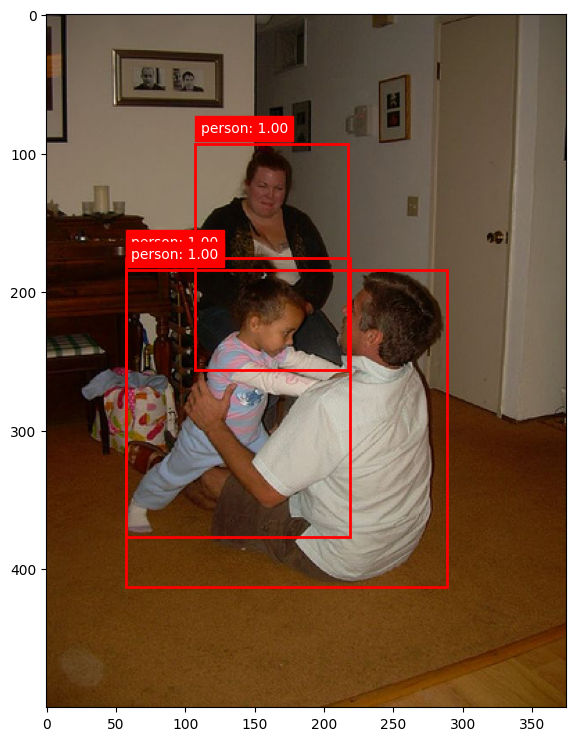

In [12]:
plot_yolo_images(train_data_y, 89)

In [13]:
#--------------Data loader, erro, otimizador, etc----------------------

train_dataloader_y = DataLoader(train_data_y, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader_y = DataLoader(val_data_y, batch_size = BATCH_SIZE, shuffle = True)

# Função de perda YOLOv3

In [16]:
class YOLOv3Loss(nn.Module):
    # (N, B, (tx,ty,tw,th,t0), S, S)

    # pred, true tensor
    # (N, B, S, S, 5+C)
    # N: batch size
    # B: n anchors
    # SxS: grid size
    # 5+C [p0, x, y, w, h, p1,...,pc]

    def __init__(self, anchors):
        super().__init__()
        self.sigmoid = nn.Sigmoid()
        self.bce = nn.BCEWithLogitsLoss()
        self.mse = nn.MSELoss()

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

        self.lambda_class = 1
        self.lambda_obj = 1

        self.anchors = anchors

    def compute_noobj_loss(self, pred, true, noobj_mask):
        loss = self.bce(
            pred[..., 0:1][noobj_mask],
            true[..., 0:1][noobj_mask],
        )

        return loss

    def compute_obj_loss(self, pred, true, obj_mask):
        loss = self.bce(
            pred[..., 0:1][obj_mask],
            true[..., 0:1][obj_mask]
        )

        return loss

    def compute_coord_loss(self, pred, true, obj_mask):
        box_pred = pred[..., 1:5][obj_mask]
        box_true = true[..., 1:5][obj_mask]

        wh_pred = box_pred[..., 2:4]
        wh_true = box_true[..., 2:4]

        N, B, S, _ = true.shape[:4]

        anchors_new= self.anchors.reshape(1, B, 1, 1, 2).expand(N, B, S, S, 2).to(true.device)
        anchor_priors = anchors_new[obj_mask]

        loss_xy = self.mse(
            self.sigmoid(box_pred[..., :2]), box_true[..., :2]
        )

        loss_wh = self.mse(
            # wh_pred, wh_true/anchor_priors
            wh_pred, wh_true
        )
        return loss_xy + loss_wh


    def compute_class_loss(self, pred, true, obj_mask):
        #print(pred.shape)
        #print(true.shape)
        #print(obj_mask.shape)
        obj_pred = pred[obj_mask]
        obj_true = true[obj_mask]
        #print(obj_pred.shape)
        #print(obj_true.shape)

        pred_class = obj_pred[..., 5:]
        #print(pred_class.shape)
        true_class = obj_true[..., 5:]
        #print(true_class.shape)

        #true_class = torch.zeros_like(pred_class)
        #true_class.scatter_(1, true_indices.unsqueeze(1), 1)

        loss = self.bce(pred_class, true_class)


        return loss

    def forward(self, pred, true):
        final_loss = 0
        for i in range(len(pred)):
            #print(true[i].shape, pred[i].shape)
            obj_mask = true[i][..., 0] == 1
            noobj_mask = ~obj_mask

            obj_loss = self.compute_obj_loss(pred[i], true[i], obj_mask)
            noobj_loss = self.compute_noobj_loss(pred[i], true[i], noobj_mask)
            coord_loss = self.compute_coord_loss(pred[i], true[i], obj_mask)
            class_loss = self.compute_class_loss(pred[i], true[i], obj_mask)

            final_loss += self.lambda_noobj * noobj_loss + \
                          self.lambda_coord * coord_loss + \
                          obj_loss + \
                          class_loss
        return final_loss.to(torch.float32)


# Classe de treino

In [17]:
class Trainer():
    def __init__(self, criterion, plot_func):
        self.criterion = criterion

        self.history = {
            "epochs": 0,
            "train_loss": [],
            "val_loss": []
        }

        self.plot_pred = plot_func

    def train_one_epoch(self, optimizer, train_loader, epoch):
        self.train()
        running_loss = 0.0

        progress_bar = tqdm(train_loader, desc = f"Epoch {epoch + 1} | Training")
        for i, (X, y) in enumerate(progress_bar):
            pred = self(X)
            loss = self.criterion(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X.size(0)

            progress_bar.set_postfix(loss = loss.item())
            #if i % 300 == 0:
            #    plot_model_output(self, train_loader.dataset, 0)

        epoch_loss = running_loss / len(train_loader.dataset)
        progress_bar.set_postfix(loss = epoch_loss)
        return epoch_loss

    def validate_one_epoch(self, optimizer, val_loader, epoch):
        self.eval()
        running_loss = 0.0

        progress_bar = tqdm(val_loader, desc = f"Epoch {epoch + 1} | Validating")
        with torch.no_grad():
            for X, y in progress_bar:

                pred = self(X)
                loss = self.criterion(pred, y)

                running_loss += loss.item() * X.size(0)

                progress_bar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(val_loader.dataset)
        progress_bar.set_postfix(loss = epoch_loss)

        self.plot_pred(self, val_loader.dataset, 1)
        
        return epoch_loss

    def save_model(self, path = None):
        if path:
            json_path = os.path.join(*path, f"{self.__class__.__name__}.json")    
            pth_path = os.path.join(*path, f"{self.__class__.__name__}.pth")
        else:
            json_path = f"{self.__class__.__name__}.json"
            pth_path = f"{self.__class__.__name__}.pth"
        with open(json_path, "w", encoding = "utf-8") as f:
            json.dump(self.history, f, ensure_ascii = False, indent = 4)
        torch.save(self.state_dict(), pth_path)
    
    def load_model(self, path = None):
        if path:
            json_path = os.path.join(*path, f"{self.__class__.__name__}.json")    
            pth_path = os.path.join(*path, f"{self.__class__.__name__}.pth")
        else:
            json_path = f"{self.__class__.__name__}.json"
            pth_path = f"{self.__class__.__name__}.pth"
        with open(json_path, "r", encoding = "utf-8") as f:
            self.history = json.load(f)
        self.load_state_dict(torch.load(pth_path, weights_only = True))

    def plot_hist(self):
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        fig.suptitle(f"Histórico de treinamento - {self.__name__}")

        axes[0].plot(hist["train_loss"], label = "Train")
        axes[0].plot(hist["val_loss"], label = "Validation")
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Loss de treino")
        axes[0].set_title("Perda no treino")
        axes[0].legend()

    def fit(self, train_loader, val_loader, optimizer, num_epochs, scheduler = None):
        for epoch in range(self.history["epochs"], self.history["epochs"] + num_epochs):
            train_loss = self.train_one_epoch(optimizer, train_loader, epoch)
            val_loss = self.validate_one_epoch(optimizer, val_loader, epoch)

            # print(f"Fim Epoch {epoch+1}:")
            # print(f"   -> Loss train: {train_loss:.3f} | Loss val: {val_loss:.3f}")
            if scheduler:
                scheduler.step(val_loss)
                print(f"   -> LR: {scheduler.get_last_lr()[0]:.6f}\n")

            self.history["epochs"] = epoch
            self.history["train_loss"].append(train_loss)
            self.history["val_loss"].append(val_loss)

            if epoch % 5 == 0:
                self.save_model()

        return self.history

# Arquitetura YOLOv3

In [18]:
@dataclass
class ConvBlockSpec:
    out_channels: int
    kernel_size: int
    stride: int
    padding: int = field(init=False)

    def __post_init__(self):
        self.padding = 1 if self.kernel_size == 3 else 0

@dataclass
class ResidualBlockSpec:
    num_repeats: int
    channels: int

@dataclass
class ScaleBlockSpec:
    from_layer: int = -1

@dataclass
class UpsampleBlockSpec:
    from_layer: int = -1

config = [
    #===DARKNET-53===
    ConvBlockSpec(32, 3, 1),
    ConvBlockSpec(64, 3, 2),
    ResidualBlockSpec(1, 64),

    ConvBlockSpec(128, 3, 2),
    ResidualBlockSpec(2, 128),

    ConvBlockSpec(256, 3, 2),
    ResidualBlockSpec(8, 256),

    ConvBlockSpec(512, 3, 2),
    ResidualBlockSpec(8, 512),

    ConvBlockSpec(1024, 3, 2),
    ResidualBlockSpec(4, 1024),
    #===DARKNET-53===

    ConvBlockSpec(512, 1, 1),
    ConvBlockSpec(1024, 1, 1),
    ScaleBlockSpec(),

    ConvBlockSpec(256, 1, 1),
    UpsampleBlockSpec(),

    ConvBlockSpec(256, 1, 1),
    ConvBlockSpec(512, 1, 1),
    ScaleBlockSpec(),

    ConvBlockSpec(128, 1, 1),
    UpsampleBlockSpec(),

    ConvBlockSpec(128, 1, 1),
    ConvBlockSpec(256, 1, 1),
    ScaleBlockSpec(),
]

In [21]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super().__init__()

        use_bias = not bn_act
        layers = []

        layers.append(
            nn.Conv2d(in_channels, out_channels, bias=use_bias, **kwargs)
        )

        if bn_act:
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.1, inplace=True))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residuals=True, num_repeats=1):
        super().__init__()

        self.use_residuals = use_residuals
        self.num_repeats = num_repeats

        layers = nn.ModuleList()

        for _ in range(num_repeats):
            layers.append(
                nn.Sequential(
                    CNNBlock(channels, channels//2, kernel_size=1),
                    CNNBlock(channels//2, channels, kernel_size=3, padding=1),
                )
            )

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        for layer in self.block:
            if self.use_residuals:
                #print(x.shape)
                x = x + layer(x)
            else:
                x = layer(x)
        return x


class ScaleBlock(nn.Module):
    def __init__(self, in_channels, num_classes, num_anchors=3):
        super().__init__()

        self.num_classes = num_classes
        self.num_anchors = num_anchors

        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2*in_channels, kernel_size=3, padding=1),
            CNNBlock(
                2*in_channels,
                self.num_anchors *(num_classes+5),
                bn_act=False,
                kernel_size=1
            ),
        )

        # [p, cx, cy, w, h, Ic1, ..., Icn] * num_anchors

    def forward(self, x):
        pred = self.pred(x)

        # N, C, W, H
        N, _, S, _ = pred.shape

        pred = pred.reshape(N, self.num_anchors, self.num_classes+5, S, S)
        pred = pred.permute(0, 1, 3, 4, 2)

        return pred


class YOLOv3(nn.Module, Trainer):
    def __init__(self, config, criterion, plot_func,
        num_anchors = 5, in_channels = 3, num_classes = 20
    ):
        super().__init__()
        Trainer.__init__(self, criterion, plot_func)
        self.config = config
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_anchors = num_anchors

        self.layers = self.gen_layers()

    def gen_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels

        for layer in self.config:
            if isinstance(layer, ConvBlockSpec):
                layers.append(CNNBlock(in_channels, **asdict(layer)))
                in_channels = layer.out_channels
            elif isinstance(layer, ResidualBlockSpec):
                layers.append(ResidualBlock(**asdict(layer)))
            elif isinstance(layer, ScaleBlockSpec):
                layers += [
                    ResidualBlock(in_channels, use_residuals=False, num_repeats=1),
                    CNNBlock(in_channels, in_channels//2, kernel_size=1),
                    ScaleBlock(in_channels//2, self.num_classes, num_anchors=self.num_anchors)
                ]
                in_channels = in_channels//2

            elif isinstance(layer, UpsampleBlockSpec):
                layers.append(nn.Upsample(scale_factor=2))
                in_channels = in_channels*3

        return layers

    def forward(self, x):
        preds = []
        route_connections = []

        #print(self.layers)

        for layer in self.layers:
            # print(isinstance(layer, CNNBlock))
            # print(isinstance(layer, ResidualBlock))
            # print(isinstance(layer, ScaleBlock))
            # print()

            if isinstance(layer, ScaleBlock):
#                print("scale")
                preds.append(layer(x))
                continue

            x = layer(x)

            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)

            if isinstance(layer, nn.Upsample):
#                print("concat")
                x = torch.cat([x, route_connections.pop()], dim=1)

        return preds


In [22]:
yolo = YOLOv3(
    config, 
    YOLOv3Loss(train_data_y.get_anchors()),
    plot_yolo_output,
    num_anchors = 3
).to(device)

In [23]:
# with torch.no_grad():
#   for x, y in train_dataloader:
#       out = yolo(x)
#   #    print(type(out))
#       boxes = train_data.decode_model_output(out)
#       for box in out:
#           #print(box[:, :, :, :, 5:])
#           argmaxes = box[..., 5:].argmax(dim = -1)
#           classes, counts = torch.unique(argmaxes, return_counts = True)
#           print(classes, counts, counts.sum())
# #      print(boxes.shape)
# #      boxes = train_data.non_maximum_supression(boxes, 0.5)
# #      for box_batch in boxes:
# #          print(box_batch.shape)
#       break

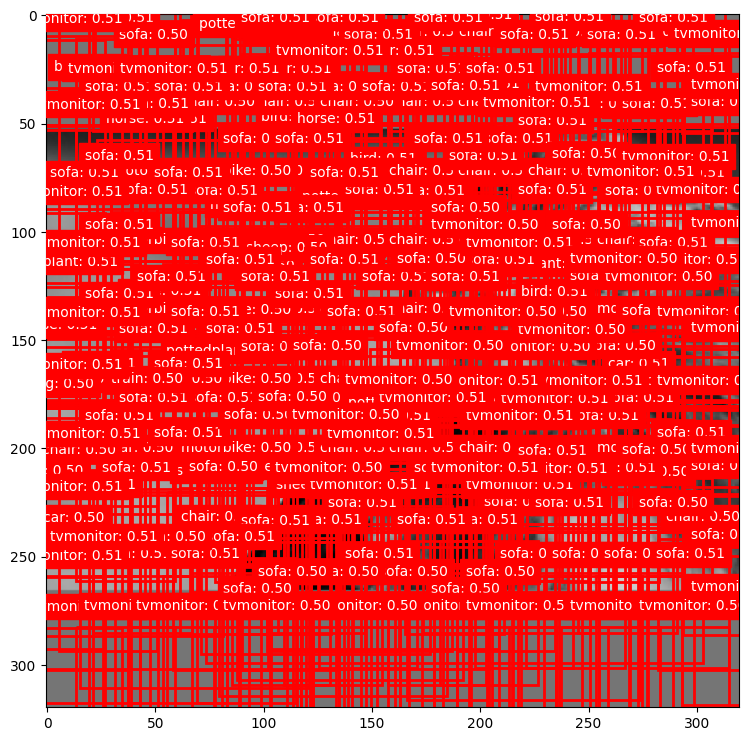

In [24]:
plot_yolo_output(yolo, train_data_y, 42, confidence = 0.5)

In [25]:
#x = torch.randn((2, 3, IMG_DIM, IMG_DIM)).to(device)
#print(x.dtype)
#out = yolo(x)

In [26]:
# for output in out:
#     print(output.shape)

In [27]:
# for i in range(2):
#     test = train_data.get_plot_image(i).to(torch.float32)
#     try:
#         output = yolo(test.unsqueeze(0))
#     except:
#         print(f"Xabu no shape {test.shape}")
#     else:
#         print(test.shape, output.shape)

In [28]:
# counter = 0

# for img in out[1]:
#     print(img.shape)
#     counter += 1

# print(counter)
#     #print(out[i].shape)

In [29]:
# len(out[1][0,0,0,0,:])

In [30]:
# res = ResidualBlock(channels=32)
# x = torch.randn((2, 32, IMG_DIM, IMG_DIM))
# res(x).shape

# mAP

In [31]:
def iou(box1, box2):
    b1_x1 = box1[0] - box1[2]/2
    b1_x2 = box1[0] + box1[2]/2
    b1_y1 = box1[1] - box1[3]/2
    b1_y2 = box1[1] + box1[3]/2

    b2_x1 = box2[..., 0] - box2[..., 2]/2
    b2_x2 = box2[..., 0] + box2[..., 2]/2
    b2_y1 = box2[..., 1] - box2[..., 3]/2
    b2_y2 = box2[..., 1] + box2[..., 3]/2

    x_overlap = torch.clamp(torch.min(b1_x2, b2_x2) - torch.max(b1_x1, b2_x1), min = 0)
    y_overlap = torch.clamp(torch.min(b1_y2, b2_y2) - torch.max(b1_y1, b2_y1), min = 0)

    intersection = x_overlap * y_overlap

    box1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
    box2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)

    union = box1_area + box2_area - intersection

    return intersection / (union + 1e-10)

In [32]:
def iou(box_a, boxes_b):
    """Calcula o IoU de uma caixa (box_a) com múltiplas caixas (boxes_b)."""
    # Calcula a área da interseção
    xy_max = torch.min(box_a[:, 2:], boxes_b[:, 2:])
    xy_min = torch.max(box_a[:, :2], boxes_b[:, :2])
    inter_dims = torch.clamp(xy_max - xy_min, min=0)
    inter_area = inter_dims[:, 0] * inter_dims[:, 1]

    # Calcula a área das caixas
    area_a = (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1])
    area_b = (boxes_b[:, 2] - boxes_b[:, 0]) * (boxes_b[:, 3] - boxes_b[:, 1])

    union_area = area_a + area_b - inter_area

    return inter_area / torch.clamp(union_area, min=1e-6)

In [33]:
def mean_average_precision(pred, true, num_classes, iou_threshold=0.5):
    average_precisions = []

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # [idx, p0, cx, cy, w, h]
        for img_idx, p in enumerate(pred):
            class_mask = p["labels"] == c
            if torch.any(class_mask):
                boxes = p["boxes"][class_mask]
                scores = p["scores"][class_mask]
                for box, score in zip(boxes, scores):
                    detections.append([img_idx, score.item(), *box.tolist()])

        for img_idx, t in enumerate(true):
            class_mask = t["labels"] == c
            if torch.any(class_mask):
                boxes = t["boxes"][class_mask]
                for box in boxes:
                    ground_truths.append([img_idx, *box.tolist()])

        if not ground_truths:
            continue


        amount_bboxes = {}
        for gt in ground_truths:
            img_idx = gt[0]
            amount_bboxes[img_idx] = amount_bboxes.get(img_idx, 0) + 1

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        detections.sort(key=lambda x: x[1], reverse=True)

        TP = torch.zeros(len(detections))
        FP = torch.zeros(len(detections))

        total_true_bboxes = len(ground_truths)

        t1 = time.time()
        for det_idx, detection in enumerate(detections):
            img_idx = detection[0]

            gt_img = torch.tensor([gt[1:] for gt in ground_truths if gt[0] == img_idx])

            if len(gt_img) == 0:
                FP[det_idx] = 1
                continue

            ious = iou(torch.tensor(detection[2:]), gt_img)
            best_iou, best_gt_idx = torch.max(ious, dim=0)

            if best_iou > iou_threshold:
                if amount_bboxes[img_idx][best_gt_idx] == 0:
                    TP[det_idx] = 1
                    amount_bboxes[img_idx][best_gt_idx] = 1 # Não pode reusar
                else:
                    FP[det_idx] = 1
            else:
                FP[det_idx] = 1
        print(f"tempo {time.time()-t1 :.2f}s")

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)

        recalls = TP_cumsum / (total_true_bboxes + 1e-10)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + 1e-10)

        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))

        ap = torch.trapz(precisions, recalls)
        average_precisions.append(ap.item())

    mean_ap = sum(average_precisions) / len(average_precisions) if average_precisions else 0
    return mean_ap

# Testes

In [34]:
def convert_to_map_format(nms_output, dim):
    formatted_predictions = []

    for batch_boxes in nms_output:
        if batch_boxes is None or batch_boxes.shape[0] == 0:
            formatted_predictions.append({
                "boxes": torch.empty((0, 4), dtype=torch.float32),
                "labels": torch.empty(0, dtype=torch.int64),
                "scores": torch.empty(0, dtype=torch.float32),
            })
            continue

        labels = batch_boxes[:, 0].to(torch.int64)
        scores = batch_boxes[:, 5]
        boxes_cxcywh = batch_boxes[:, 1:5]

        formatted_predictions.append({
            "boxes": boxes_cxcywh,
            "labels": labels,
            "scores": scores,
        })

    return formatted_predictions

In [35]:
optimizer = torch.optim.Adam(yolo.parameters(), lr = 0.0001)
yolo.fit(train_dataloader_y, val_dataloader_y, optimizer, 30)

Epoch 1 | Training:   1%|▏         | 91/6850 [00:15<19:21,  5.82it/s, loss=8.43]


KeyboardInterrupt: 

In [38]:
dataset = val_dataloader_y.dataset

for batch in val_dataloader_y:

    print(val_data_y.get_formated_boxes(idx = 0))

    break
    x, y = batch
    pred = yolo(x)
    decoded_boxes = dataset.decode_model_output(pred, dim=IMG_DIM)
    nms_boxes = dataset.non_maximum_supression(decoded_boxes, confidence=0.25, min_IoU=0.45)
    pred_for_map = convert_to_map_format(nms_boxes, dim=IMG_DIM)

    break

{'labels': tensor([0], dtype=torch.uint64), 'boxes': tensor([[155.2000, 163.5181, 309.1200, 205.9640]])}


In [39]:
print(pred_for_map[0])

NameError: name 'pred_for_map' is not defined

In [40]:
'''
    0,0 ------> x (width)
     |
     | (Left,Top)
     |      *_________
     |      |         |
            |         |
     y      |_________|
  (height)            *
                (Right,Bottom)
'''
pass

In [41]:
preds = [
    # Imagem 1
    {
        # [cx, cy, w, h]
        "boxes": torch.tensor([[250, 30, 400, 150], [50, 40, 300, 190]], dtype=torch.float32),
        "scores": torch.tensor([0.9, 0.75], dtype=torch.float32),
        "labels": torch.tensor([0, 1], dtype=torch.int32),
    },
    # Imagem 2
    {
        "boxes": torch.tensor([[100, 200, 250, 350]], dtype=torch.float32),
        "scores": torch.tensor([0.8], dtype=torch.float32),
        "labels": torch.tensor([1], dtype=torch.int32),
    },
    {
        "boxes": torch.tensor([[100, 300, 250, 350]], dtype=torch.float32),
        "scores": torch.tensor([0.8], dtype=torch.float32),
        "labels": torch.tensor([1], dtype=torch.int32),
    },
]


targets = [
    # Imagem 1 - Ground Truth
    {
        "boxes": torch.tensor([[260, 40, 390, 160]], dtype=torch.float32),
        "labels": torch.tensor([0], dtype=torch.int32),
    },
    # Imagem 2 - Ground Truth
    {
        "boxes": torch.tensor([[110, 210, 240, 360], [10, 10, 50, 50]], dtype=torch.float32),
        "labels": torch.tensor([1, 0], dtype=torch.int32),
    },
    {
        "boxes": torch.tensor([[110, 300, 240, 360], [10, 10, 50, 50]], dtype=torch.float32),
        "labels": torch.tensor([1, 0], dtype=torch.int32),
    },
]

In [42]:
import torch
import random

def generate_realistic_detection_data(
    num_images: int = 3,
    image_size: tuple[int, int] = (800, 600),
    num_classes: int = 2,
    max_gt_boxes: int = 4,
    # --- Novos parâmetros para controlar o realismo ---
    detection_chance: float = 0.9,      # 90% de chance de detectar um objeto que existe
    correct_class_chance: float = 0.95, # 95% de chance de classificar corretamente
    max_noise_factor: float = 0.25,     # Ruído máximo de 15% nas coordenadas da caixa
    max_false_positives: int = 20,       # Máximo de 2 detecções "fantasmas" por imagem
):
    """
    Gera dados realistas de predição e ground truth, onde as predições
    são baseadas nos alvos (targets) com ruído e imprecisões.

    Args:
        num_images (int): O número de imagens para gerar dados.
        image_size (tuple[int, int]): As dimensões da imagem (largura, altura).
        num_classes (int): O número total de classes de objetos.
        max_gt_boxes (int): O número máximo de caixas de ground truth por imagem.
        detection_chance (float): Probabilidade de um objeto do ground truth ser detectado.
        correct_class_chance (float): Probabilidade da classe prevista ser a correta.
        max_noise_factor (float): Fator máximo de ruído para as coordenadas da caixa.
        max_false_positives (int): Número máximo de detecções falsas (sem alvo correspondente).

    Returns:
        tuple[list[dict], list[dict]]: Uma tupla contendo a lista de predições (preds)
                                       e a lista de alvos (targets).
    """
    all_preds = []
    all_targets = []
    img_width, img_height = image_size

    for _ in range(num_images):
        # 1. Gera os dados de Ground Truth (targets) como antes
        num_target_boxes = random.randint(1, max_gt_boxes)
        target_boxes = []
        target_labels = []
        for _ in range(num_target_boxes):
            w = random.randint(50, img_width // 3)
            h = random.randint(50, img_height // 3)
            cx = random.randint(w // 2, img_width - w // 2)
            cy = random.randint(h // 2, img_height - h // 2)
            target_boxes.append([cx, cy, w, h])
            target_labels.append(random.randint(0, num_classes - 1))

        targets_dict = {
            "boxes": torch.tensor(target_boxes, dtype=torch.float32),
            "labels": torch.tensor(target_labels, dtype=torch.int32),
        }
        all_targets.append(targets_dict)

        # 2. Gera as Predições (preds) baseadas nos Targets
        pred_boxes = []
        pred_scores = []
        pred_labels = []

        # Itera sobre cada objeto real (ground truth)
        for gt_box, gt_label in zip(target_boxes, target_labels):
            # Simula falhas de detecção (Falsos Negativos)
            if random.random() > detection_chance:
                continue # O modelo "não viu" este objeto

            # O objeto foi detectado, agora adicionamos imprecisões
            base_score = 1.0

            # Adiciona ruído à caixa (imprecisão de localização)
            gt_cx, gt_cy, gt_w, gt_h = gt_box
            noise_w = gt_w * max_noise_factor
            noise_h = gt_h * max_noise_factor

            pred_cx = gt_cx + random.uniform(-noise_w, noise_w)
            pred_cy = gt_cy + random.uniform(-noise_h, noise_h)
            pred_w = gt_w + random.uniform(-noise_w, noise_w)
            pred_h = gt_h + random.uniform(-noise_h, noise_h)

            pred_boxes.append([pred_cx, pred_cy, pred_w, pred_h])

            # O score diminui com base na imprecisão
            base_score -= random.uniform(0.0, 0.25)

            # Simula erros de classificação
            if random.random() > correct_class_chance:
                # Gera uma classe diferente da correta
                possible_labels = list(range(num_classes))
                possible_labels.remove(gt_label)
                pred_labels.append(random.choice(possible_labels))
                base_score -= random.uniform(0.1, 0.3) # Penalidade maior por errar a classe
            else:
                pred_labels.append(gt_label)

            pred_scores.append(round(max(0.3, base_score), 2))

        # 3. Simula detecções extras (Falsos Positivos)
        num_false_positives = random.randint(0, max_false_positives)
        for _ in range(num_false_positives):
            w = random.randint(40, img_width // 4)
            h = random.randint(40, img_height // 4)
            cx = random.randint(w // 2, img_width - w // 2)
            cy = random.randint(h // 2, img_height - h // 2)
            pred_boxes.append([cx, cy, w, h])
            pred_labels.append(random.randint(0, num_classes - 1))
            pred_scores.append(round(random.uniform(0.3, 0.65), 2)) # Scores mais baixos para FPs

        preds_dict = {
            "boxes": torch.tensor(pred_boxes, dtype=torch.float32),
            "scores": torch.tensor(pred_scores, dtype=torch.float32),
            "labels": torch.tensor(pred_labels, dtype=torch.int32),
        }
        all_preds.append(preds_dict)

    return all_preds, all_targets




In [43]:
preds, targets = generate_realistic_detection_data(
    num_images=6000
)

In [44]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

metric = MeanAveragePrecision(box_format="cxcywh")
metric.update(preds=preds, target=targets)

print(metric.compute()["map_50"].item())
print(f"{mean_average_precision(preds, targets, 20) :.5f}")

ModuleNotFoundError: No module named 'torchmetrics'

## Teste IoU

In [45]:
predicted_box = torch.tensor(
    [1, 1, 2, 2],
)

# Caixas de verdade-fundamental (duas caixas para comparar)
ground_truth_boxes = torch.tensor([
    # Caixa 1: Grande sobreposição com a predição
    [2, 2, 2, 2],
    # Caixa 2: Nenhuma sobreposição com a predição
    [-1, -1, 1, 1],
    [-1, -1, 1, 1],
    [-1, -1, 1, 1],
    [2, 2, 2, 2],
])

iou(predicted_box, ground_truth_boxes)

IndexError: too many indices for tensor of dimension 1

In [46]:
x = torch.rand([1, 3, IMG_DIM, IMG_DIM])
yolo(x)[0][..., 5:].argmax(-1)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

# Dataset UNet

In [47]:
banned_images = ["2009_005069_2_8", "2009_004969_1_0", "2011_002863_0_4", "2009_000455_2_14", "2009_004969_2_0"]

In [48]:
def filter_(path):
    for image_name in banned_images:
        if image_name in path:
            return False
    return True

In [49]:
#------------------Dataset para carregar as imagens---------------------
class UNetDataset(Dataset):

    #inicializa o dataset
    def __init__(self, type_, dim = 416, unet_dataset_path = ["unet_dataset"], device = "cpu"):
        #Carrega o caminho do conjunto desejado (val, train, test)
        self.base_path_data = os.path.join(*unet_dataset_path, "images", f"{type_}")
        self.base_path_labels = os.path.join(*unet_dataset_path, "labels", f"{type_}")
        
        #self.images = glob(os.path.join(self.base_path_data, "*.jpg"))
        self.images = list(filter(filter_, glob(os.path.join(self.base_path_data, "*.jpg"))))
        self.device = device
        self.dim = dim

        self.classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
    
        self.toTensor = ToTensor()

    def __len__(self):
        return len(self.images)

    def letterbox_data(self, image, label):
        if image.shape[2] > image.shape[1]: #W > H
            scale_factor = self.dim/image.shape[2]
            new_H = int(scale_factor * image.shape[1])
            new_dims = (new_H, self.dim)

            resize_i = T.Resize(new_dims)
            resize_l = T.Resize(new_dims, interpolation = T.InterpolationMode.NEAREST)
            
            a = int(round((self.dim - new_H)/2 - 0.1))
            b = int(round((self.dim - new_H)/2 + 0.1))
            padding = T.Pad([0, a, 0, b], fill = 117)

        elif image.shape[2] < image.shape[1]: #W < H
            scale_factor = self.dim/image.shape[1]
            new_W = int(scale_factor * image.shape[2])
            new_dims = (self.dim, new_W)

            resize_i = T.Resize(new_dims)
            resize_l = T.Resize(new_dims, interpolation = T.InterpolationMode.NEAREST)

            a = int(round((self.dim - new_W)/2 - 0.1))
            b = int(round((self.dim - new_W)/2 + 0.1))
            padding = T.Pad([a, 0, b, 0], fill = 117)

        else: #W = H
            resize_i = T.Resize((self.dim, self.dim))
            resize_l = T.Resize((self.dim, self.dim), interpolation = T.InterpolationMode.NEAREST)

            padding = lambda x: x

        return padding(resize_i(image)), padding(resize_l(label))

    def __getitem__(self, idx):
        img_path = self.images[idx]
        name = img_path.split("/")[-1].split(".")[0]

        class_ = int(name.split("_")[-1])

        label_path = os.path.join(self.base_path_labels, f"{name}.png")
        label = Image.open(label_path).convert("RGB")

        colors = label.getcolors(label.size[0] * label.size[1])
        most_frequent_colors = sorted(colors, key = lambda item: item[0], reverse = True)
        try:
            if most_frequent_colors[0][1] != (0, 0, 0) and most_frequent_colors[0][1] != (224, 224, 192):
                r, g, b = most_frequent_colors[0][1]
            elif most_frequent_colors[1][1] != (0, 0, 0) and most_frequent_colors[1][1] != (224, 224, 192):
                r, g, b = most_frequent_colors[1][1]
            else:
                r, g, b = most_frequent_colors[2][1]
        except:
            print(name)
            return 0
        #Faz uma array de lookup pra converter o rgb pra classe mais eficientemente
        lookup_classes = np.ones((256, 256, 256), dtype = "uint8") * len(self.classes)
        lookup_classes[r, g, b] = class_

        image = decode_image(img_path).to(torch.float).to(self.device)
        label = self.toTensor(label) * 255

        image, label = self.letterbox_data(image, label.to(torch.uint8))

        label_permute = label.permute(1, 2, 0)
        r_channel = label_permute[:, :, 0]
        g_channel = label_permute[:, :, 1]
        b_channel = label_permute[:, :, 2]

        label = torch.Tensor(lookup_classes[r_channel, g_channel, b_channel]).to(self.device)
        return image, label.to(int)

    #Função auxiliar para pegar a imagem original sem normalização
    def get_plot_image(self, idx):
        img_path = self.images[idx]
        return decode_image(img_path)

In [50]:
train_data_u = UNetDataset("train", 256, unet_dataset_path = [UNET_DATASET_PATH], device = device)
val_data_u = UNetDataset("val", 256, unet_dataset_path = [UNET_DATASET_PATH], device = device)
train_data_u[0][0].shape, torch.unique(train_data_u[0][1], return_counts=True)

(torch.Size([3, 256, 256]),
 (tensor([16, 20], device='cuda:0'), tensor([26095, 39441], device='cuda:0')))

In [51]:
train_dataloader_u = DataLoader(train_data_u, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader_u = DataLoader(val_data_u, batch_size = BATCH_SIZE, shuffle = True)

In [52]:
def display_image(model, dataset, index, deeplab = False):
    with torch.no_grad():
        if not deeplab:
            pred = model(dataset[index][0]).cpu()
        else:
            pred = model(dataset[index][0].unsqueeze(0))[0].cpu()
        pred_softmax = pred.argmax(axis = 0)


    fig, axs = plt.subplots(1, 3, figsize = (10, 24))

    axs[0].imshow(dataset.get_plot_image(index).permute(1, 2, 0).to(int).cpu())
    axs[0].set_title("Original image")

    axs[1].imshow(colors[pred_softmax].cpu())
    axs[1].set_title("Prediction")

    axs[2].imshow(colors[dataset[index][1].to(int).cpu()].to(int).cpu())
    axs[2].set_title("Original label")
    #train_data[0][1].unique(return_counts = True)

    plt.show()


In [53]:
#---------------------------UNet incial----------------------------------
class ConvBlock(nn.Module):
    def __init__(self, index = 1):
        super().__init__()

        self.index = index
        out_channels = 2 ** (5 + index)
        in_channels = out_channels//2 if index != 1 else 3

        self.conv_1 = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = "same")
        self.conv_2 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, padding = "same")
        self.max_pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        y = self.max_pool(x)
        return x, y

class UpBlock(nn.Module):
    def __init__(self, index = 1):
        super().__init__()

        self.index = index
        in_channels = 2 ** (6 + index)
        out_channels = in_channels//2

        self.transpose = nn.ConvTranspose2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 2, stride = 2)
        self.conv_1 = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = "same")
        self.conv_2 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, padding = "same")
        self.relu = nn.ReLU()

    def forward(self, x, skip):
        x = self.transpose(x)
        cat_dim = len(x.shape) - 3
        x = torch.cat((skip, x), dim = cat_dim)
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        return x

class UNet(nn.Module, Trainer):
    def __init__(self, criterion, plot_func, depth = 4, num_classes = 21):
        super().__init__()
        Trainer.__init__(self, criterion, plot_func)
        self.convs = nn.ModuleList()
        for i in range(depth):
            self.convs.append(ConvBlock(i + 1).to(device))

        in_channels = 2 ** (5 + depth)
        out_channels = in_channels * 2
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = "same"), nn.ReLU(),
            nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, padding = "same"), nn.ReLU()
        )

        self.ups = nn.ModuleList()
        for i in range(depth):
            self.ups.insert(0, UpBlock(i + 1).to(device))

        self.classifier = nn.Conv2d(in_channels = 64, out_channels = num_classes, kernel_size = 1, padding = "same")

    def forward(self, x):
        skip_connections = []
        for block in self.convs:
            conv_out, x = block(x)
            skip_connections.insert(0, conv_out)

        x = self.bottleneck(x)

        for i, block in enumerate(self.ups):
            x = block(x, skip_connections[i])

        logits = self.classifier(x)

        return logits

In [54]:
#--------------Focal Loss-------------------
class FocalLoss(nn.Module):
    def __init__(self, gamma = 2, weight = None) -> None:
        super().__init__()
        self.gamma = gamma
        self.weight = weight

    def __call__(self, inputs, targets):
        ce_loss = torch.nn.functional.cross_entropy(inputs, targets, reduction='none', weight = self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

In [56]:
#-------------------------Inferência básica----------------------------------
unet = UNet(FocalLoss(), display_image).to(device)
pred = unet(val_data_u[0][0])
pred_softmax = pred.argmax(axis = 0)
print(pred.shape)

torch.Size([21, 256, 256])


In [57]:
colors = torch.tensor([[64 , 128, 64],
[192, 0  , 128],
[0  , 128, 192],
[0  , 128, 64],
[128, 0  , 0],
[64 , 0  , 128],
[64 , 0  , 192],
[192, 128, 64],
[192, 192, 128],
[64 , 64 , 128],
[128, 0  , 192],
[192, 0  , 64],
[128, 128, 64],
[192, 0  , 192],
[128, 64 , 64],
[64 , 192, 128],
[64 , 64 , 0],
[128, 64 , 128],
[128, 128, 192],
[0  , 0  , 192],
[0, 0, 0]], dtype = torch.uint8)

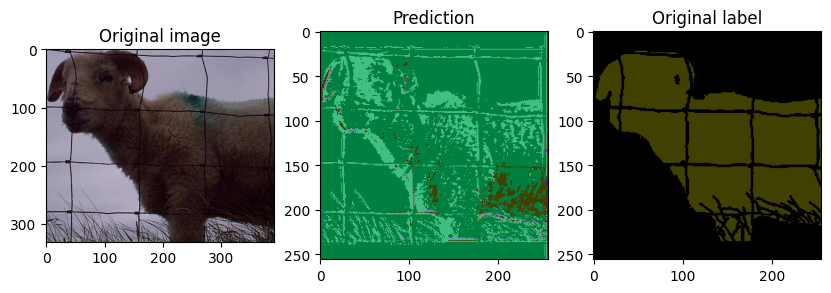

In [58]:
#---------------------Plot de imagens----------------------------
display_image(unet, train_data_u, 0)

In [59]:
optimizer = torch.optim.Adam(unet.parameters(), lr = 0.001)
unet.fit(train_dataloader_u, val_dataloader_u, optimizer, 30)

Epoch 1 | Training:   1%|          | 33/2771 [00:07<09:43,  4.69it/s, loss=1.04] 


KeyboardInterrupt: 